In [36]:
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
pd.set_option('mode.chained_assignment', None)

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.figsize"] = 20, 6

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

#import machine learning models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

In [ ]:
cols = ['csn', 'date', 'article', 'salesquantity', 'price']
df = pd.read_csv('parsed_transactions.csv', usecols=cols)
df.date = pd.to_datetime(df.date)
df.head()

### Train Test Data:

- We have 5 months of data (Feb - June)
- Objective: Given customer purchase behaviour in 1st 2 months, predict customer purchase day in 3rd month
- Train Data: Feb, Mar -> Apr
- Test Data: Apr, May -> June

### Predictor & Target Generation:

- Target Labels: NextPurchaseDay: Diff. between last purchase day (train data) and first purchase day (test data)
- Predictors: Customer_csn

### Customer behaviour Features

1. RFM scores (Recency, Frequency, Monetary) to segment customers into (low, med, high value)
2. Days between last 3 purchases
3. Mean and Std of difference between purchases

In [ ]:
# NextPurchaseDay

# Feb, Mar -> Apr
tx_user_2m = df[df['date'] <= "2018-03-31"]
tx_user_1m = df[(df['date'] >= "2018-04-01") & (df['date'] <= "2018-04-30")]

# # Mar, Apr -> May
# tx_user_2m = df[df['date'] <= "2018-04-30"]
# tx_user_1m = df[(df['date'] >= "2018-05-01") & (df['date'] <= "2018-05-31")]

In [ ]:
max_purchase_date = tx_user_2m.groupby('csn', as_index=False).date.max()
max_purchase_date.columns = ['csn', 'max_purchase_date']

min_purchase_date = tx_user_1m.groupby('csn', as_index=False).date.min()
min_purchase_date.columns = ['csn', 'min_purchase_date']

tx_user = pd.merge(max_purchase_date, min_purchase_date, how='left', on='csn')
tx_user['next_purchase_day'] = (tx_user['min_purchase_date'] - tx_user['max_purchase_date']).dt.days
tx_user['next_purchase_day'].fillna(999, inplace=True)
tx_user = tx_user[['csn', 'next_purchase_day']]

In [ ]:
# Recency
tx_recency = tx_user_2m.groupby('csn', as_index=False).date.max()
tx_recency.columns = ['csn', 'recent_tx_date']

tx_recency['recency'] = (tx_recency['recent_tx_date'].max() - tx_recency['recent_tx_date']).dt.days
tx_user = pd.merge(tx_user, tx_recency, how='left', on='csn')

#plot recency
plot_data = [
    go.Histogram(
        x=tx_user['recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# clustering for Recency
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(tx_user[['recency']])
tx_user['recency_cluster'] = kmeans.predict(tx_user[['recency']])

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


#order recency clusters
tx_user = order_cluster('recency_cluster', 'recency', tx_user,False)

#print cluster characteristics
tx_user.groupby('recency_cluster')['recency'].describe()

In [ ]:
# Frequency
tx_frequency = tx_user_2m.groupby('csn', as_index=False).date.count()
tx_frequency.columns = ['csn', 'frequency']

tx_user = pd.merge(tx_user, tx_frequency, how='left', on='csn')

#plot recency
plot_data = [
    go.Histogram(
        x=tx_user['frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# clustering for Recency
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(tx_user[['frequency']])
tx_user['frequency_cluster'] = kmeans.predict(tx_user[['frequency']])

#order recency clusters
tx_user = order_cluster('frequency_cluster', 'frequency', tx_user,True)

#print cluster characteristics
tx_user.groupby('frequency_cluster')['frequency'].describe()

In [ ]:
# Revenue

tx_user_2m['revenue'] = tx_user_2m['price'] * tx_user_2m['salesquantity']
tx_user_2m['revenue'] = np.log(tx_user_2m['revenue']) # turn into gaussian distribution

# remove outliers (gaussian)
data_mean = tx_user_2m['revenue'].mean()
data_std = tx_user_2m['revenue'].std()
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
lower = max(lower, 0)
tx_user_2m.loc[tx_user_2m['revenue'] > upper, 'revenue'] = upper
tx_user_2m.loc[tx_user_2m['revenue'] < lower, 'revenue'] = lower

# remove outliers (quantiles, non gaussian)
# q25 = tx_user_2m['revenue'].quantile(.25)
# q75 = tx_user_2m['revenue'].quantile(.75)
# iqr = q75 - q25
# cut_off = iqr * 1.5
# lower, upper = max(0, q25 - cut_off), q75 + cut_off
# print(lower, upper)

# Merge
tx_revenue = tx_user_2m.groupby('csn', as_index=False).revenue.sum()
tx_revenue.columns = ['csn', 'revenue']
tx_user = pd.merge(tx_user, tx_revenue, how='left', on='csn')

In [ ]:
# # Find optimal K
# # Min. SSE with 8 clusters
# sse={}
# tx_revenue_only = tx_user[['revenue']]
# for k in range(1, 15):
#     kmeans = KMeans(n_clusters=k, random_state=21).fit(tx_revenue_only)
#     tx_revenue_only["clusters"] = kmeans.labels_
#     sse[k] = kmeans.inertia_
# plt.figure()
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel("Number of cluster")
# plt.show()

#plot revenue
plot_data = [
    go.Histogram(
        x=tx_user['revenue']
    )
]

plot_layout = go.Layout(
        title='Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# clustering for Recency
kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(tx_user[['revenue']])
tx_user['revenue_cluster'] = kmeans.predict(tx_user[['revenue']])

#order recency clusters
tx_user = order_cluster('revenue_cluster', 'revenue', tx_user, True)

#print cluster characteristics
tx_user.groupby('revenue_cluster')['revenue'].describe()

In [ ]:
tx_user['overall_score'] = tx_user['recency_cluster'] + tx_user['frequency_cluster'] + tx_user['revenue_cluster']
tx_user.groupby('overall_score')[['recency', 'frequency', 'revenue']].mean()

tx_user['segment'] = 'Low-Value'
tx_user.loc[tx_user['overall_score']>3,'segment'] = 'Mid-Value' 
tx_user.loc[tx_user['overall_score']>6,'segment'] = 'High-Value'

In [ ]:
#Revenue vs Frequency
tx_graph = tx_user

plot_data = [
    go.Scatter(
        x=tx_graph.query("segment == 'Low-Value'")['frequency'],
        y=tx_graph.query("segment == 'Low-Value'")['revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'Mid-Value'")['frequency'],
        y=tx_graph.query("segment == 'Mid-Value'")['revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'High-Value'")['frequency'],
        y=tx_graph.query("segment == 'High-Value'")['revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue Recency

tx_graph = tx_user.query("revenue < 50000 and recency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("segment == 'Low-Value'")['recency'],
        y=tx_graph.query("segment == 'Low-Value'")['revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'Mid-Value'")['recency'],
        y=tx_graph.query("segment == 'Mid-Value'")['revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'High-Value'")['recency'],
        y=tx_graph.query("segment == 'High-Value'")['revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Recency vs Frequency
tx_graph = tx_user.query("recency < 50000 and frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("segment == 'Low-Value'")['recency'],
        y=tx_graph.query("segment == 'Low-Value'")['frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'Mid-Value'")['recency'],
        y=tx_graph.query("segment == 'Mid-Value'")['frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("segment == 'High-Value'")['recency'],
        y=tx_graph.query("segment == 'High-Value'")['frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# Previous 3 purchase dates and difference in days
tx_user_2m['prev_purchase_date'] = tx_user_2m.groupby('csn').date.shift(1)
tx_user_2m['t2_purchase_date'] = tx_user_2m.groupby('csn').date.shift(2)
tx_user_2m['t3_purchase_date'] = tx_user_2m.groupby('csn').date.shift(3)

tx_user_2m['diff1'] = (tx_user_2m.date - tx_user_2m.prev_purchase_date).dt.days
tx_user_2m['diff2'] = (tx_user_2m.date - tx_user_2m.t2_purchase_date).dt.days
tx_user_2m['diff3'] = (tx_user_2m.date - tx_user_2m.t3_purchase_date).dt.days

In [ ]:
tx_day_diff = tx_user_2m.groupby('csn', as_index=False).agg({'diff1': ['mean', 'std']})
tx_day_diff.columns = ['csn', 'diff1_mean', 'diff1_std']

tx_order_last = tx_user_2m.drop_duplicates(subset=['csn'], keep='last')
tx_order_last.dropna(inplace=True)

tx_day_diff = pd.merge(tx_day_diff, tx_order_last, on='csn')
tx_user = pd.merge(tx_user, tx_day_diff[['csn', 'diff1', 'diff2', 'diff3', 'diff1_mean', \
                                         'diff1_std']], on='csn')
tx_user

In [ ]:
tx_class = tx_user.copy()
tx_class.drop(columns=['recent_tx_date'],inplace=True)
# tx_class = pd.get_dummies(tx_class, columns=['recency_cluster', 'frequency_cluster', 'revenue_cluster', \
#                                             'overall_score', 'segment'])

tx_class = pd.get_dummies(tx_class, columns=['segment'])
tx_class

In [ ]:
tx_class['next_purchase_day_range'] = 2
tx_class.loc[tx_class.next_purchase_day>10,'next_purchase_day_range'] = 1
tx_class.loc[tx_class.next_purchase_day>30,'next_purchase_day_range'] = 0
tx_class

/var/folders/qr/_5h5wgv97lvfd41bf4hy04mw0000gn/T/ipykernel_82067/301594435.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

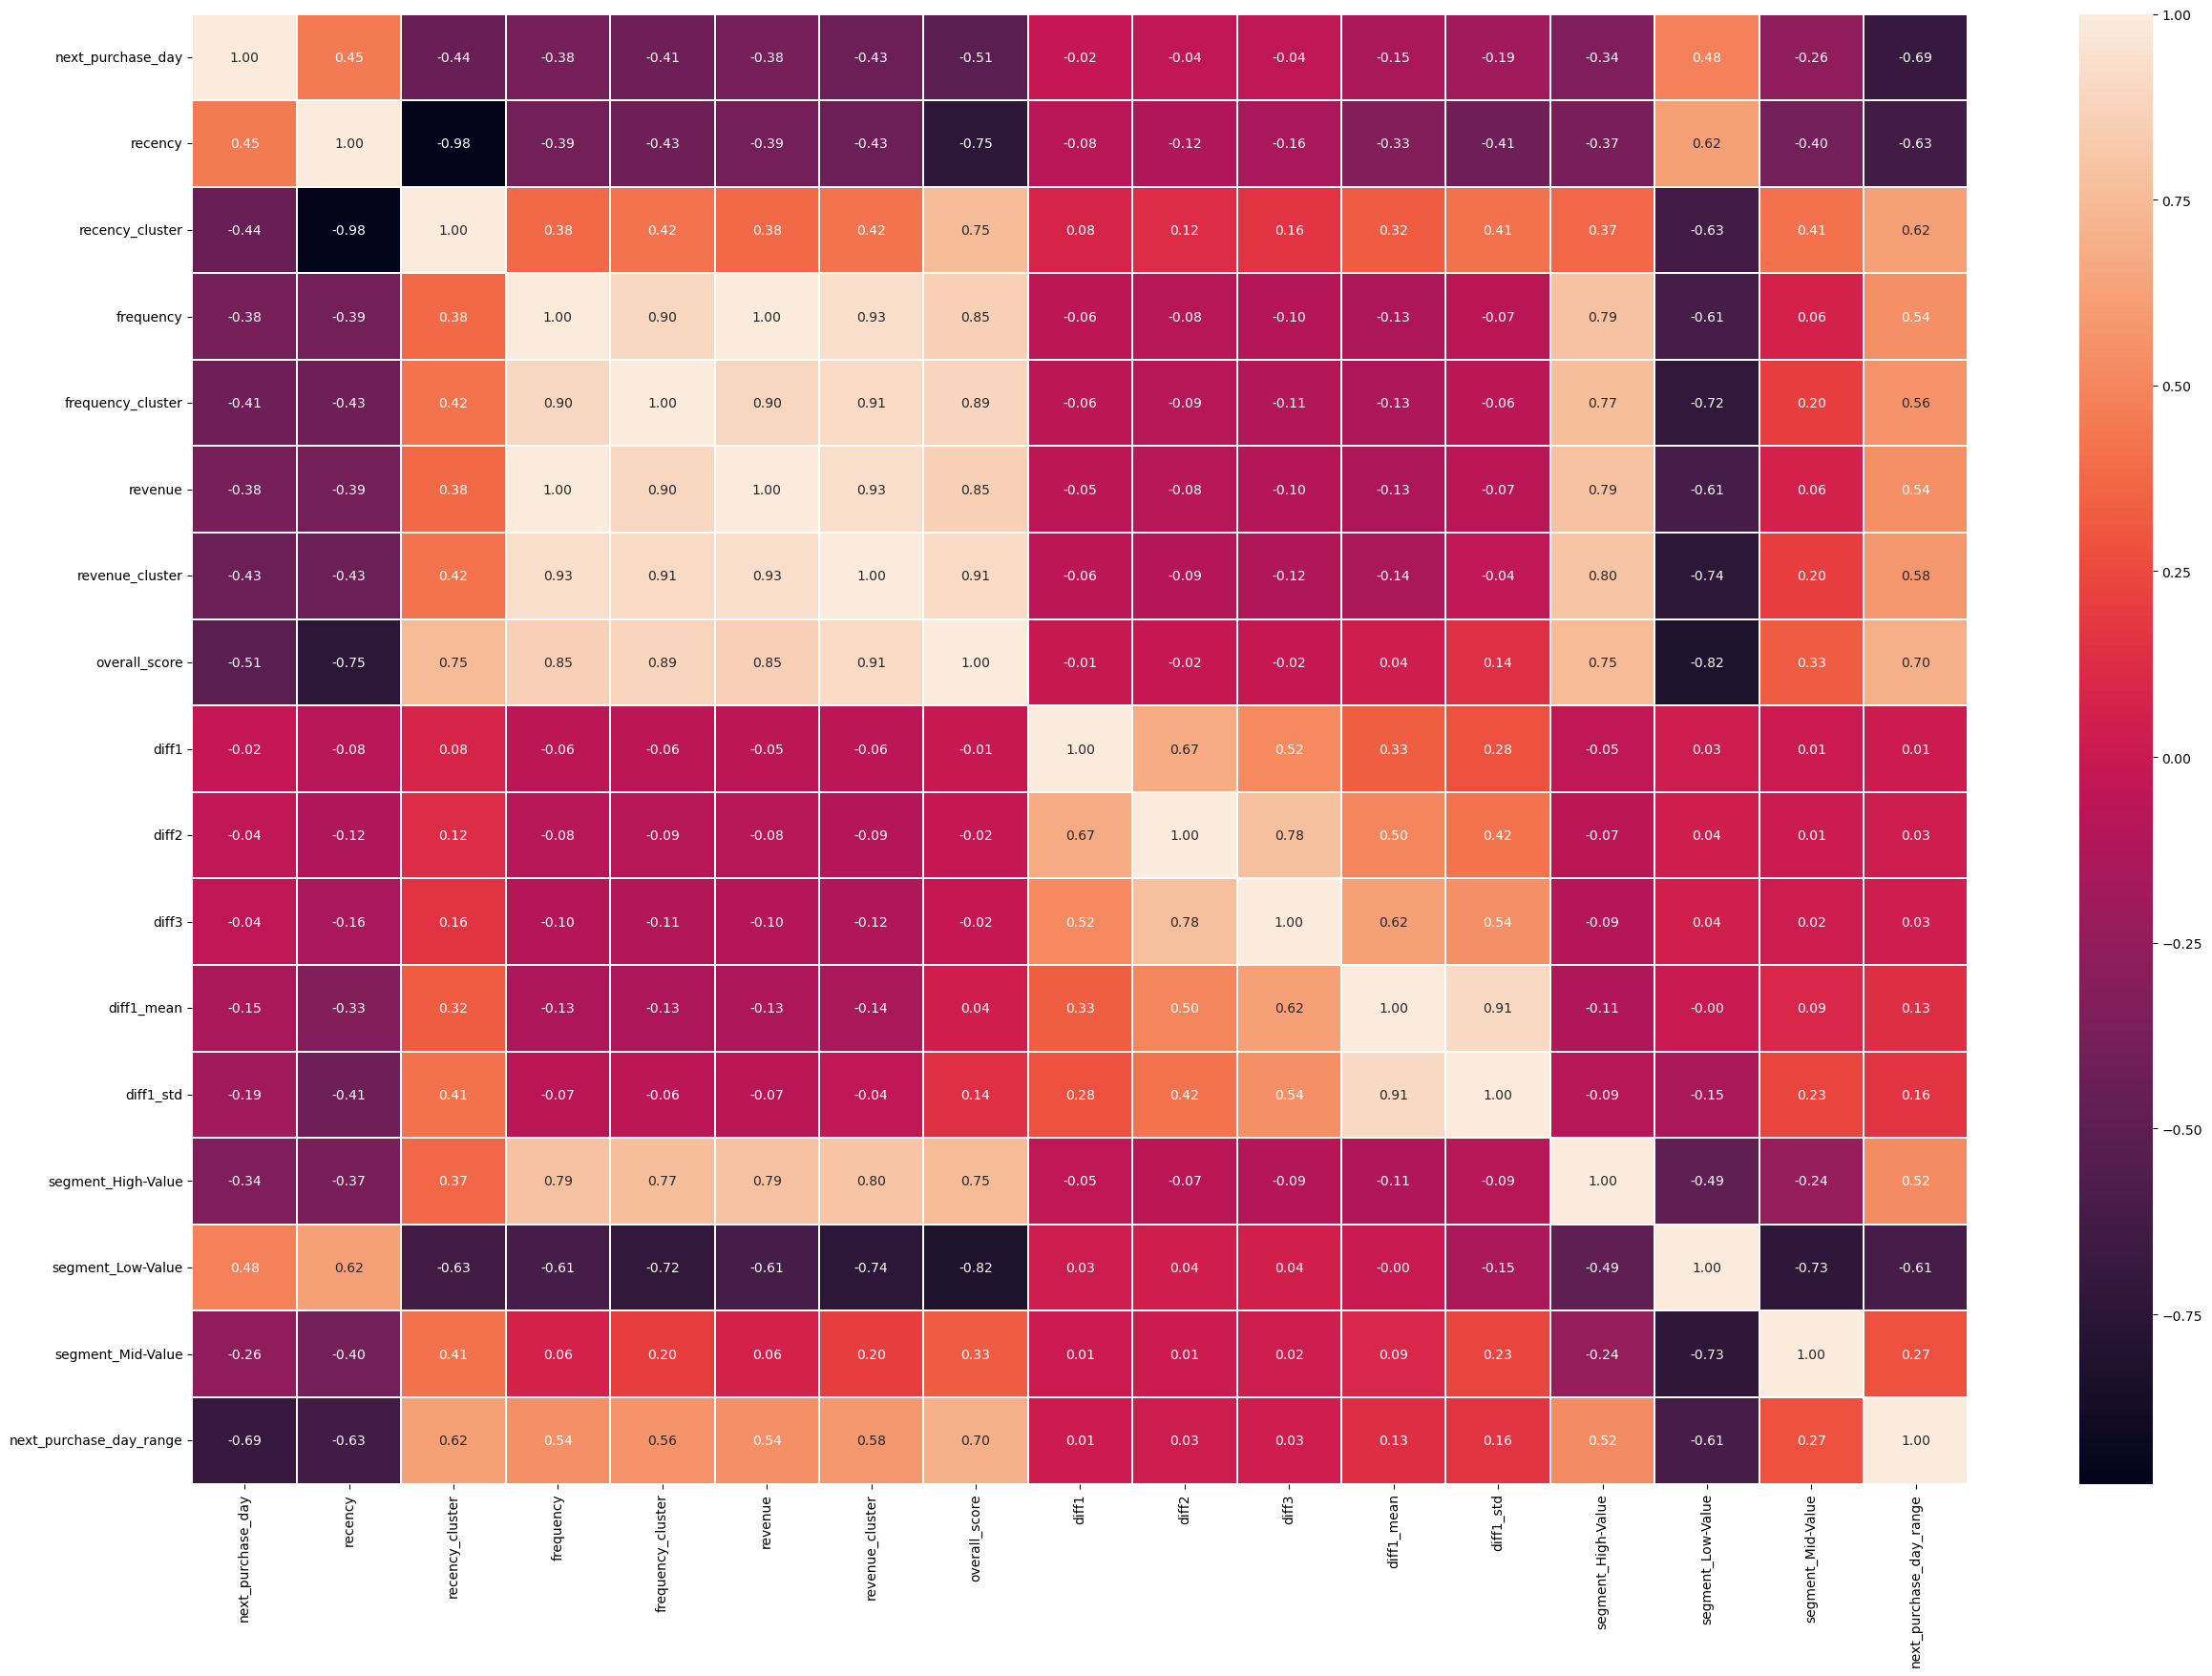

In [15]:
plt.figure(figsize = (30,20))
sns.heatmap(tx_class.corr(), annot = True, linewidths=0.2, fmt=".2f")

In [32]:
X, y = tx_class.drop(columns=['csn', 'next_purchase_day', 'next_purchase_day_range']), tx_class.next_purchase_day_range
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

#create an array of models
models = []
models.append(("LR",LogisticRegression(max_iter=1000)))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

for name, model in models:
    kfold = KFold(n_splits=2)
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print(name, score)

/Users/shubhamdawande/miniconda3/envs/env1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/shubhamdawande/miniconda3/envs/env1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

LR [0.76232508 0.76248923]
NB [0.72508073 0.73341947]
RF [0.7489774  0.74741602]
SVC [0.70419806 0.6961671 ]
Dtree [0.71022605 0.70305771]
XGB [0.75371367 0.75538329]
KNN [0.72680301 0.72286822]


In [41]:
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.83
Accuracy of XGB classifier on test set: 0.78


In [38]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy', n_jobs=-1, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.7692970964305483)

<Axes: >

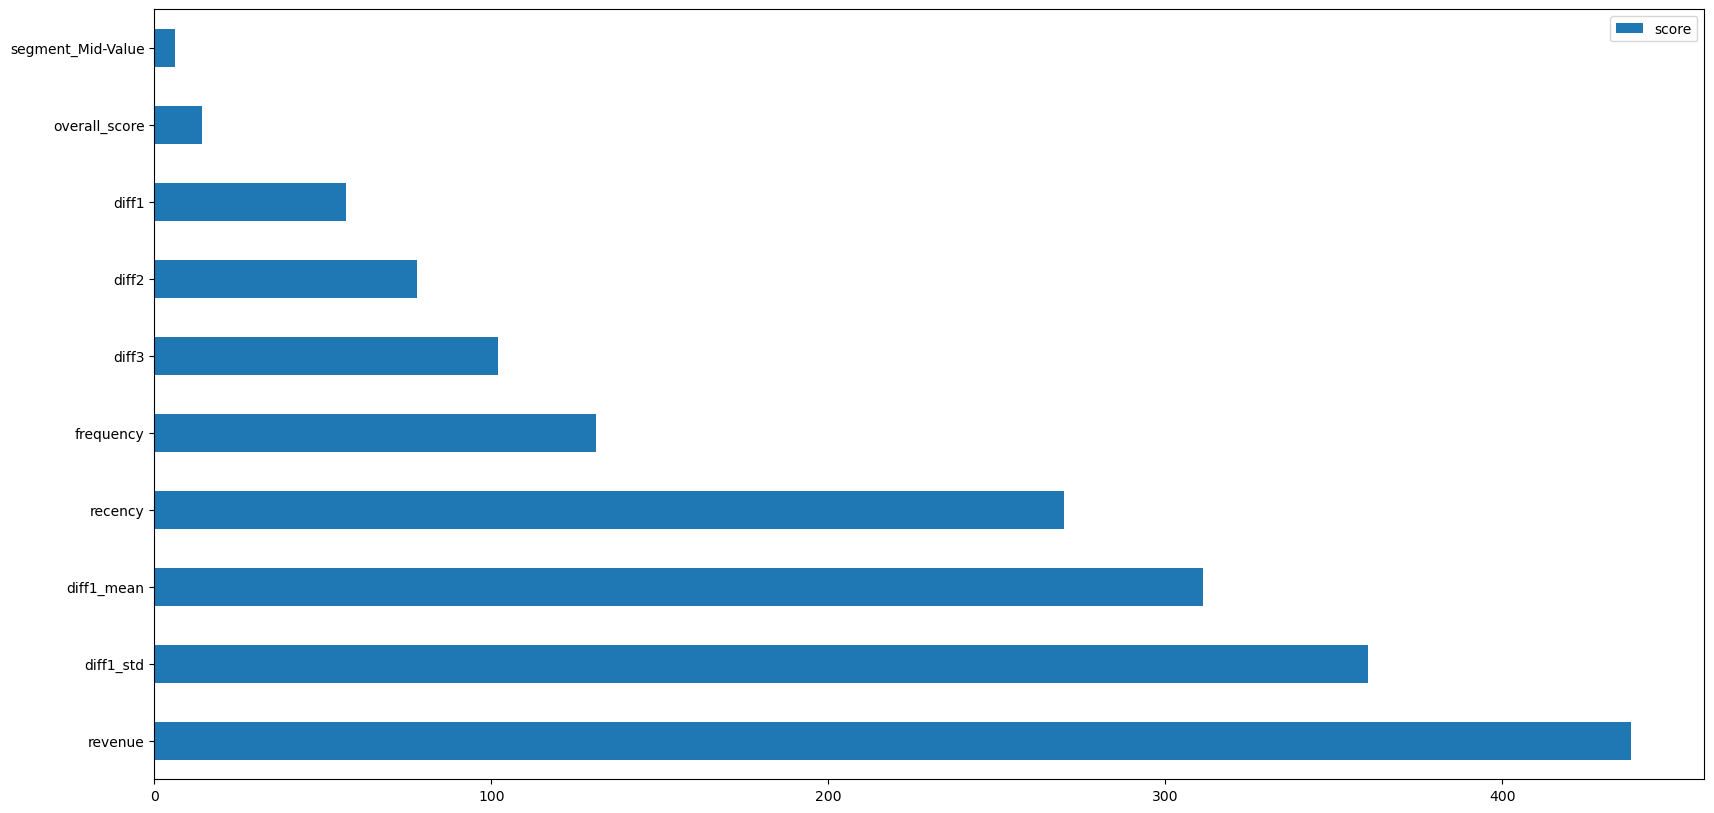

In [45]:
# feature importance
feature_important = xgb_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top features